In [1]:
from pyspark import SparkConf,SparkContext
from pyspark import rdd
conf=SparkConf().setMaster("local[*]").setAppName("First_APP")
sc=SparkContext(conf=conf)

In [2]:
import numpy as np
path = 'E:/machine_data/bike_sharing/hour.csv'
raw_data = sc.textFile(path) 
records =raw_data.map(lambda x: x.split(',')) 
records=sc.parallelize(records.collect()[1:]) #去头
num_data = records.count() 
first = records.first() 
print ('数据的第一行:',first)
print ('数据样本数:',num_data)

数据的第一行: ['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
数据样本数: 17379


结果显示，数据集中共有17 379个小时的记录。接下来的实验，我们会忽略记录中的instant和dteday 。忽略两个记录次数的变量casual 和registered ， 只保留cnt （ casual 和

registered的和）。最后就剩下12个变量，其中前8个是类型变量，后4个是归一化后的实数变量。对其中8个类型变量，我们使用之前提到的二元编码，剩下4个实数变量不做处理。

因为变量records下文经常要用到，此处对其进行缓存：

In [3]:
records.cache()

ParallelCollectionRDD[3] at parallelize at PythonRDD.scala:475

In [4]:
#为了将类型特征表示成二维形式，我们将特征值映射到二元向量中非0的位置。下面定义这样一个映射函数：
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [5]:
print ('第三个特征的类别编码： %s '%get_mapping(records,2))

第三个特征的类别编码： {'1': 2, '4': 0, '2': 3, '3': 1} 


In [6]:
mappings = [get_mapping(records, i) for i in range(2,10)]   #对类型变量的列（第2~9列）应用映射函数
print ('类别特征打编码字典:',mappings)
cat_len = sum(map(len,[i for i in mappings]))        #类别特征的个数                 
#cat_len = sum(map(len, mappings))
#print map(len,mappings)

num_len = len(records.first()[11:15])                      #数值特征的个数
total_len = num_len+cat_len                                  #所有特征的个数
print ('类别特征的个数： %d'% cat_len)
print ('数值特征的个数： %d'% num_len)
print ('所有特征的个数:：%d' % total_len)

类别特征打编码字典: [{'1': 2, '4': 0, '2': 3, '3': 1}, {'0': 0, '1': 1}, {'10': 1, '1': 7, '8': 8, '9': 6, '12': 2, '6': 5, '4': 0, '5': 10, '11': 9, '2': 11, '7': 3, '3': 4}, {'14': 17, '0': 16, '8': 12, '6': 9, '19': 18, '21': 14, '23': 7, '11': 21, '18': 5, '16': 1, '15': 10, '3': 6, '10': 0, '1': 11, '17': 13, '2': 23, '9': 19, '4': 3, '13': 20, '22': 15, '12': 2, '20': 4, '7': 8, '5': 22}, {'0': 0, '1': 1}, {'6': 2, '1': 3, '4': 0, '5': 5, '0': 4, '2': 6, '3': 1}, {'0': 0, '1': 1}, {'1': 2, '4': 0, '2': 3, '3': 1}]
类别特征的个数： 57
数值特征的个数： 4
所有特征的个数:：61


------------------------
1.1 为线性模型创建特征向量
------------------------

接下来用上面的映射函数将所有类型特征转换为二元编码的特征。为了方便对每条记录提取特征和标签，我们分别定义两个辅助函数extract_features和extract_label。如下为代码实现，注意需要引入numpy和MLlib的LabeledPoint对特征向量和目标变量进行封装：

In [16]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

def extract_features(record): 
    cat_vec = np.zeros(cat_len) 
    step = 0
    for i,raw_feature in enumerate(record[2:9]):
        dict_code = mappings[i]
        index = dict_code[raw_feature]
        cat_vec[index+step] = 1
        step = step+len(dict_code)
    num_vec = np.array([float(raw_feature) for raw_feature in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    print (1)
    return float(record[-1])

在extract_features函数中，我们遍历了数据的每一行每一列，根据已经创建的映射对每个特征进行二元编码。其中step变量用来确保非0特征在整个特征向量中位于正确的位置（另外一种实现方法是将若干较短的二元向量拼接在一起）。数值向量直接对之前已经被转换成浮点数的数据用numpy的array进行封装。最后将二元向量和数值向量拼接起来。定义extract_label函数将数据中的最后一列cnt的数据转换成浮点数。

下面对数据进行特征提取：


In [9]:
data = records.map(lambda point: LabeledPoint(extract_label(point),extract_features(point)))
first_point = data.first()

print ('原始特征向量:' +str(first[2:]))
print ('标签:' + str(first_point.label))
print ('对类别特征进行独热编码之后的特征向量: \n' + str(first_point.features))
print ('对类别特征进行独热编码之后的特征向量长度:' + str(len(first_point.features)))

原始特征向量:['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
标签:16.0
对类别特征进行独热编码之后的特征向量: 
[0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
对类别特征进行独热编码之后的特征向量长度:61


-----------------
1.2 为决策树创建特征向量
-----------------

我们已经知道，决策树模型可以直接使用原始数据（不需要将类型数据用二元向量表示）。因此，只需要创建一个分割函数简单地将所有数值转换为浮点数，最后用numpy的array封装：

In [31]:
def extract_features_dt(record):
    print (1)
    return np.array(list(map(float, record[2:14])))# map之后一定要转为list格式，否则得到的就是一个map对象，之后的操作np.array(map)就是无效操作

In [33]:
record=[1,1,1,1,1,1,1,11,1,1,1,1,1,1,1]
a=extract_features_dt(record)
print (type(a))
print (a)

1
<class 'numpy.ndarray'>
[  1.   1.   1.   1.   1.  11.   1.   1.   1.   1.   1.   1.]


In [34]:
data_dt = records.map(lambda point: LabeledPoint(extract_label(point), extract_features_dt(point)))
first_point_dt = data_dt.first()
print ('决策树特征向量: '+str(first_point_dt.features))
print ('决策树特征向量长度: '+str(len(first_point_dt.features)))

决策树特征向量: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
决策树特征向量长度: 12


-----------------------------
2 回归模型的训练和应用
-----------------------------

使用决策树和线性模型训练回归模型的步骤和使用分类模型相同，都是简单将训练数据封装在LabeledPoint的RDD中，并送到相关的train方法上进行训练。注意在Scala中，如果要自定义不同的模型参数（比如SGD优化的正则化和步长），就需要初始化一个新的模型实例，使用实例的optimizer变量访问和设置参数。

Python提供了方便我们访问所有模型参数的方法，因此只要使用相关方法即可。可以通过引入相关模块，并调用train方法中的help函数查看这些方法的具体细节：


In [36]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
help(LinearRegressionWithSGD.train)

Help on method train in module pyspark.mllib.regression:

train(data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.0, regType=None, intercept=False, validateData=True, convergenceTol=0.001) method of builtins.type instance
    Train a linear regression model using Stochastic Gradient
    Descent (SGD). This solves the least squares regression
    formulation
    
        f(weights) = 1/(2n) ||A weights - y||^2
    
    which is the mean squared error. Here the data matrix has n rows,
    and the input RDD holds the set of rows of A, each with its
    corresponding right hand side label y.
    See also the documentation for the precise formulation.
    
    :param data:
      The training data, an RDD of LabeledPoint.
    :param iterations:
      The number of iterations.
      (default: 100)
    :param step:
      The step parameter used in SGD.
      (default: 1.0)
    :param miniBatchFraction:
      Fraction of data to be used for each SGD iteratio

In [31]:
help(DecisionTree.trainRegressor)

Help on method trainRegressor in module pyspark.mllib.tree:

trainRegressor(data, categoricalFeaturesInfo, impurity='variance', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0) method of builtins.type instance
    Train a decision tree model for regression.
    
    :param data:
      Training data: RDD of LabeledPoint. Labels are real numbers.
    :param categoricalFeaturesInfo:
      Map storing arity of categorical features. An entry (n -> k)
      indicates that feature n is categorical with k categories
      indexed from 0: {0, 1, ..., k-1}.
    :param impurity:
      Criterion used for information gain calculation.
      The only supported value for regression is "variance".
      (default: "variance")
    :param maxDepth:
      Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1
      means 1 internal node + 2 leaf nodes).
      (default: 5)
    :param maxBins:
      Number of bins used for finding splits at each node.
      (default: 32)
    :param mi

In [37]:
#在bike sharing 数据上训练回归模型
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept =False)
true_vs_predicted = data.map(lambda point:(point.label,linear_model.predict(point.features)))
print ('线性回归模型对前5个样本的预测值: '+ str(true_vs_predicted.take(5)))

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


线性回归模型对前5个样本的预测值: [(16.0, 117.89250386724842), (40.0, 116.22496123192109), (32.0, 116.02369145779234), (13.0, 115.6708801675443), (1.0, 115.56315650834314)]


输出结果：

线性回归模型对前5个样本的预测值: [(16.0, 117.89250386724844), (40.0, 116.22496123192109), (32.0, 116.02369145779232), (13.0, 115.67088016754431), (1.0, 115.56315650834314)]




上述代码中我们没有使用默认的迭代次数和步长，而是使用较小的迭代次数以缩短训练时间，关于步长的设置我们稍后会详细介绍。




接下来，我们在trainRegressor中使用默认参数来训练决策树模型（相当于深度为5的树）。注意，这里训练数据集是从原始特征中提取的，名为data_dt（不同于之前线性模型中使用的二元编码的特征）。另外，我们还需要为categoricalFeaturesInfo传入一个字典参数，这个字典参数将类型特征的索引映射到特征中类型的数目。如果某个特征值不在这个字典中，则将其映射设置为空：


In [41]:
dt_model = DecisionTree.trainRegressor(data_dt,{})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p:p.label)
true_vs_predicted_dt = actual.zip(preds)
print ('决策树回归模型对前5个样本的预测值: '+str(true_vs_predicted_dt.take(5)))
print ('决策树模型的深度: ' + str(dt_model.depth()))
print ('决策树模型的叶子节点个数: '+str(dt_model.numNodes()))

决策树回归模型对前5个样本的预测值: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
决策树模型的深度: 5
决策树模型的叶子节点个数: 63


-------------------------
3 评估回归模型的性能
-------------------------

In [42]:
#3.1 均方误差和均方根误差,MSE是平方误差的均值，用作最小二乘回归的损失函数
def squared_error(actual, pred): 
    return (pred-actual)**2 

#3.2 平均绝对误差,MAE是预测值和实际值的差的绝对值的平均值。
def abs_error(actual, pred): 
    return np.abs(pred-actual) 

#3.3 均方根对数误差,这个度量方法虽然没有MSE和MAE使用得广，但被用于Kaggle中以bike sharing作为数据集的比赛。
#    RMSLE可以认为是对预测值和目标值进行对数变换后的RMSE。这个度量方法适用于目标变量值域很大，并且没有必要对预测值和目标值的误差进行惩罚的情况。
#    另外，它也适用于计算误差的百分率而不是误差的绝对值。
def squared_log_error(pred, actual): 
    return (np.log(pred+1)-np.log(actual+1))**2

#3.4 R-平方系数
#R-平方系数，也称判定系数，用来评估模型拟合数据的好坏，常用于统计学中。R-平方系数具体测量目标变量的变异度（degree of variation），最终结果为0到1的一个值，1表示模型能够完美拟合数据。


In [36]:
mse = true_vs_predicted.map(lambda kv: squared_error(kv[0], kv[1])).mean() 
mae = true_vs_predicted.map(lambda kv: abs_error(kv[0], kv[1])).mean() 
rmsle = np.sqrt(true_vs_predicted.map(lambda kv: squared_log_error(kv[0], kv[1])).mean()) 
print ('Linear Model - Mean Squared Error: %2.4f' % mse )
print ('Linear Model - Mean Absolute Error: %2.4f' % mae )
print ('Linear Model - Root Mean Squared Log Error: %2.4f' % rmsle)

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


-----------------
3.5.2 决策树
-----------------

In [43]:
mse_dt = true_vs_predicted_dt.map(lambda kv: squared_error(kv[0], kv[1])).mean()
mae_dt = true_vs_predicted_dt.map(lambda kv: abs_error(kv[0], kv[1])).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda kv: squared_log_error(kv[0], kv[1])).mean())
print ('Decision Tree - Mean Squared Error: %2.4f' % mse_dt)
print ('Decision Tree - Mean Absolute Error: %2.4f' % mae_dt)
print ('Decision Tree - Root Mean Squared Log Error: %2.4f' %rmsle_dt)

Decision Tree - Mean Squared Error: 11611.4860
Decision Tree - Mean Absolute Error: 71.1502
Decision Tree - Root Mean Squared Log Error: 0.6251


----------------------------
4 改进模型性能和参数调优
----------------------------

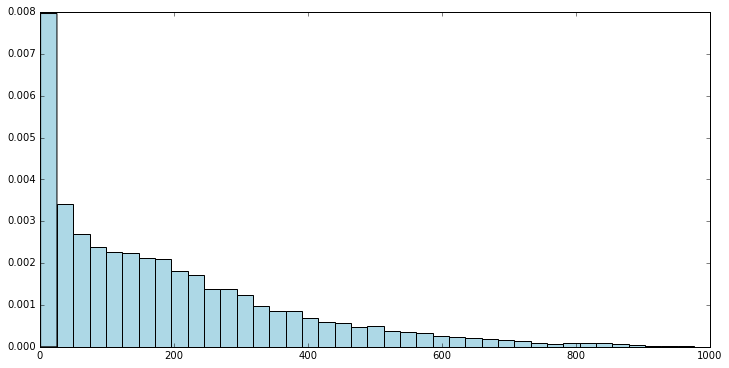

In [44]:
%matplotlib inline
import matplotlib
from matplotlib.pyplot import hist
import numpy as np 
import matplotlib.pyplot as plt 

targets = records.map(lambda r: float(r[-1])).collect() 
hist(targets, bins=40, color='lightblue', normed=True) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6)
plt.show()

从上图可以看出，目标变量的分布完全不符合正态分布。







解决该问题的一种方法是对目标变量进行变换，比如用目标值的对数代替原始值，通常称为对数变换（这种变换也可以用到特征值上）。下面绘制对目标变量进行对数变换后的分布直方图。


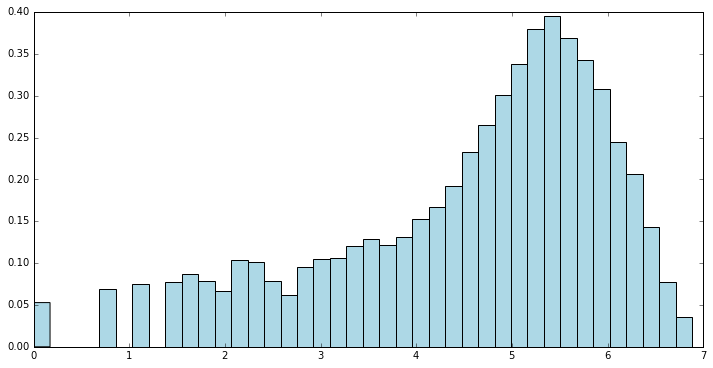

In [45]:
log_targets = records.map(lambda r : np.log(float(r[-1]))).collect() 
plt.hist(log_targets, bins = 40, color ='lightblue', normed =True) 
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

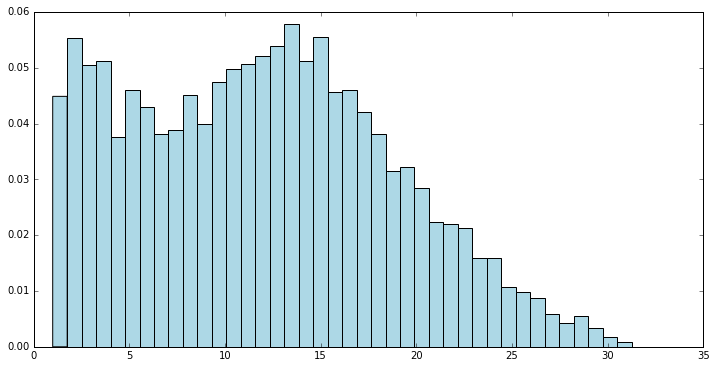

In [46]:
#另一种常用的变换是平方根变换。该变换适用于目标变量不为负数且值域很大的情形。下面绘制对目标变量进行平方根变换后的分布直方图。
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect() 
plt.hist(sqrt_targets, bins=40, color='lightblue', normed=True) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6) 

----------------------
4.1 目标变量变换对模型的影响
----------------------

In [48]:
data_log = data.map(lambda lp:LabeledPoint(np.log(lp.label),lp.features)) 
model_log =LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1) 
true_vs_predicted_log = data_log.map(lambda p:(np.exp(p.label),np.exp(model_log.predict(p.features))))

#计算模型的MSE,MAE,RMSLE
mse_log = true_vs_predicted_log.map(lambda kv: squared_error(kv[0], kv[1])).mean() 
mae_log = true_vs_predicted_log.map(lambda kv: abs_error(kv[0], kv[1])).mean() 
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda kv: squared_log_error(kv[0], kv[1])).mean())

print ('Linear Model —— Mean Squared Error:%2.4f'% mse_log )
print ('Linear Model —— Mean Absolue Error:%2.4f'% mae_log )
print ('Linear Model —— Root Mean Squared Log Error:%2.4f'% rmsle_log )
print ('Linear Model —— Non log-transformed predictions:\n'+ str(true_vs_predicted.take(3)))
print ('Linear Model —— Log-transformed predictions:\n'+ str(true_vs_predicted_log.take(3)))

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


Linear Model —— Mean Squared Error:50685.5559
Linear Model —— Mean Absolue Error:155.2955
Linear Model —— Root Mean Squared Log Error:1.5411
Linear Model —— Non log-transformed predictions:
[(16.0, 117.89250386724842), (40.0, 116.22496123192109), (32.0, 116.02369145779234)]
Linear Model —— Log-transformed predictions:
[(15.999999999999998, 28.080291845456287), (40.0, 26.959480191001845), (32.0, 26.654725629458078)]


将上述结果与原始数据集训练的模型性能进行对比，可以发现，三个评价指标MSE,MAE,RMSLE都没有得到提升，书上说RMSLE的性能得到了提升，也许是Spark版本所设置的默认参数不一样导致的。




下面对决策树模型做同样的分析，其代码如下：


In [49]:
data_dt_log = data_dt.map(lambda lp:LabeledPoint(np.log(lp.label), lp.features)) 
dt_model_log = DecisionTree.trainRegressor(data_dt_log,{}) 
preds_log = dt_model_log.predict(data_dt_log.map(lambda p:p.features)) 
actual_log = data_dt_log.map(lambda p: p.label) 
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda kv:(np.exp(kv[0]), np.exp(kv[1])))

#计算模型的MSE,MAE,RMSLE
mse_log_dt = true_vs_predicted_dt_log.map(lambda kv: squared_error(kv[0], kv[1])).mean() 
mae_log_dt = true_vs_predicted_dt_log.map(lambda kv: abs_error(kv[0], kv[1])).mean() 
rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda kv: squared_log_error(kv[0], kv[1])).mean())

print ('Decision Tree —— Mean Squared Error:%2.4f'% mse_log_dt )
print ('Decision Tree —— Mean Absolue Error:%2.4f'% mae_log_dt )
print ('Decision Tree —— Root Mean Squared Log Error:%2.4f'% rmsle_log_dt )
print ('Decision Tree —— Non log-transformed predictions:\n'+ str(true_vs_predicted_dt.take(3)))
print ('Decision Tree —— Log-transformed predictions:\n'+str(true_vs_predicted_dt_log.take(3)))

Decision Tree —— Mean Squared Error:14781.5760
Decision Tree —— Mean Absolue Error:76.4131
Decision Tree —— Root Mean Squared Log Error:0.6406
Decision Tree —— Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Decision Tree —— Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907305)]


-------------------------
4.2  模型参数调优
-------------------------

到目前为止，本文讨论了同一个数据集上对MLlib中的回归模型进行训练和评估的基本概率。接下来，我们使用交叉验证方法来评估不同参数对模型性能的影响。




首先，我们将原始数据按比率划分为train，test数据集,原书当中pyspark版本还没有randomSplit这个函数，所以用如下的方式处理：


In [50]:
data_with_idx = data.zipWithIndex().map(lambda kv:(kv[1],kv[0])) 
test = data_with_idx.sample(False,0.2,42) 
train = data_with_idx.subtractByKey(test)

In [51]:
#如果使用的版本pyspark1.6.1以后已经有了函数randomSplit，这里直接使用randomSplit：
train_test_data_split = data.randomSplit([0.8,0.2],123) 
train = train_test_data_split[0] 
test = train_test_data_split[1]
print ('测试集的样本数:',test.count())
print ('训练集的样本数:',train.count())

测试集的样本数: 3439
训练集的样本数: 13940


In [52]:
train_test_data_dt_split = data_dt.randomSplit([0.8,0.2],123) 
train_dt = train_test_data_dt_split[0] 
test_dt = train_test_data_dt_split[1]

---------------------
参数设置对线性模型的影响
---------------------

In [54]:
#RMSLE作为评价指标
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model =LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, 
                                         regType=regType,intercept=intercept)
    testLabel_vs_testPrediction = test.map(lambda point:(point.label, model.predict(point.features)))
    rmsle = np.sqrt(testLabel_vs_testPrediction.map(lambda kv:squared_log_error(kv[0],kv[1])).mean())
    return rmsle

In [55]:
#迭代次数对模型的影响：
params = [1, 5, 10, 20, 50, 100]
metrics = [evaluate(train, test, param, 0.01, 0.0, 'l2', False) for param in params]
print (params)
print (metrics)

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[1, 5, 10, 20, 50, 100]
[2.9137698128225531, 2.0634428706028474, 1.7927137287456878, 1.5896208197217547, 1.4301701331167367, 1.3862968178830628]


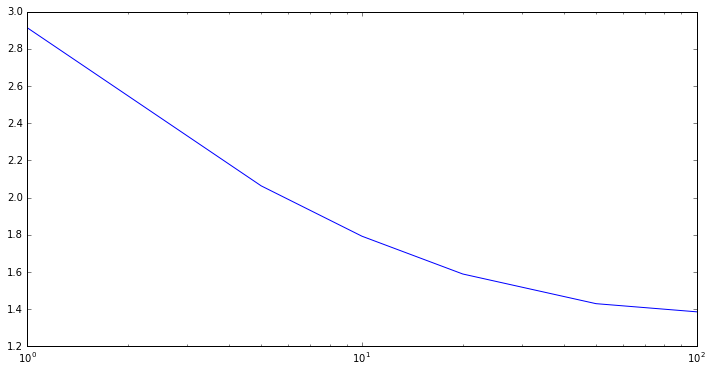

In [56]:
#绘制迭代次数与RMSLE的关系图：
plt.plot(params, metrics) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6) 
plt.xscale('log')
plt.show()

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
D:\anaconda1\lib\site-packages\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
D:\anaconda1\lib\site-packages\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


the rmsle:1.792714 when step :0.010000
the rmsle:1.429770 when step :0.025000
the rmsle:1.391788 when step :0.050000
the rmsle:1.464901 when step :0.100000
the rmsle:1.432130 when step :0.500000
the rmsle:nan when step :1.000000


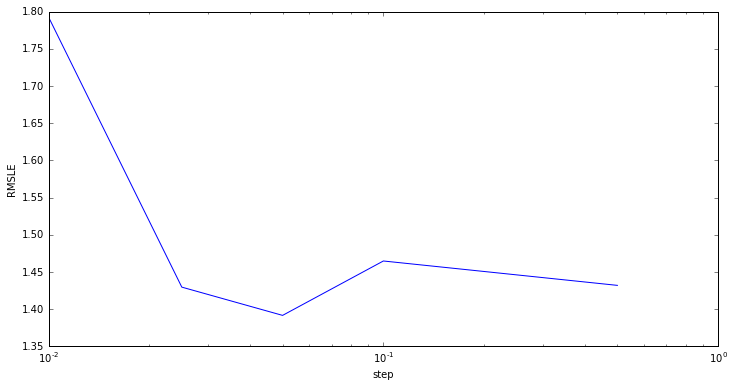

In [57]:
#评估step(步长)对模型的影响：
params=[0.01,0.025,0.05,0.1,0.5,1.0] 
metrics =[evaluate(train, test,10,param,0.0,'l2',False)for param in params]
for i in range(len(params)):
    print ('the rmsle:%f when step :%f'%(metrics[i],params[i]))

#绘制步长与RMSLE的关系图：
plt.plot(params, metrics) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6) 
plt.xscale('log')
plt.xlabel('step')
plt.ylabel('RMSLE')
plt.show()

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


the rmsle:1.464901 when regParam :0.000000
the rmsle:1.464282 when regParam :0.010000
the rmsle:1.458826 when regParam :0.100000
the rmsle:1.414960 when regParam :1.000000
the rmsle:1.398280 when regParam :5.000000
the rmsle:1.541495 when regParam :10.000000
the rmsle:1.846367 when regParam :20.000000


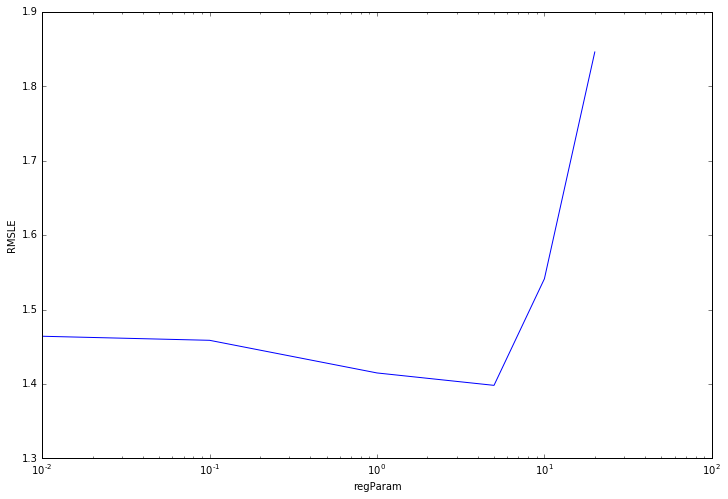

In [58]:
#不同正则化系数对模型的影响
#先看L2正则化系数对模型的影响
params=[0.0,0.01,0.1,1.0,5.0,10.0,20.0]
metrics =[evaluate(train, test,10,0.1, param,'l2',False) for param in params]
for i in range(len(params)):
    print ('the rmsle:%f when regParam :%f'%(metrics[i],params[i]))

#绘制L2正则化系数与RMSLE的关系图：
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.xscale('log')
plt.xlabel('regParam')
plt.ylabel('RMSLE')
plt.show()

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


the rmsle:1.464901 when regParam :0.000000
the rmsle:1.464868 when regParam :0.010000
the rmsle:1.464572 when regParam :0.100000
the rmsle:1.461826 when regParam :1.000000
the rmsle:1.436437 when regParam :10.000000
the rmsle:1.750440 when regParam :100.000000
the rmsle:4.795064 when regParam :1000.000000


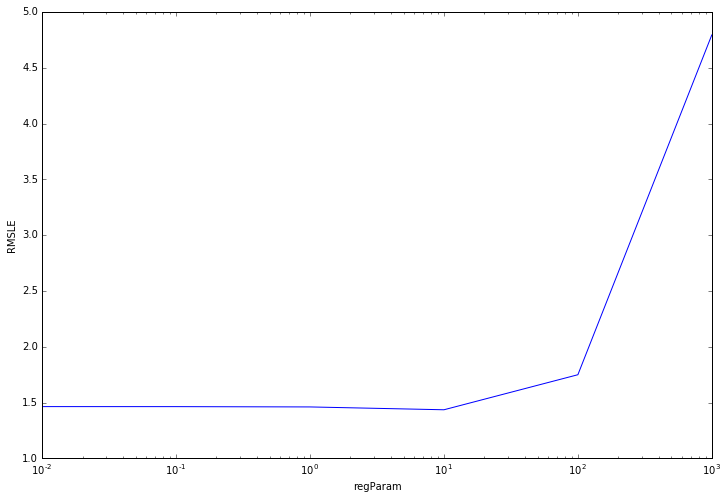

In [59]:
#再看L1正则化系数对模型的影响
params=[0.0,0.01,0.1,1.0,10.0,100.0,1000.0]
metrics =[evaluate(train, test,10,0.1, param,'l1',False) for param in params]
for i in range(len(params)):
    print ('the rmsle:%f when regParam :%f'%(metrics[i],params[i]))

#绘制L1正则化系数与RMSLE的关系图：
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.xscale('log')
plt.xlabel('regParam')
plt.ylabel('RMSLE')
plt.show()

从上图可以看到，当使用一个较大的正则化参数时，RMSLE性能急剧下降。




想必大家都知道，使用L1正则化可以得到稀疏的权重向量，我们看看刚刚得到的L1正则化模型是否真是如此呢？


In [61]:
model_l1 = LinearRegressionWithSGD.train(train,10,0.1,regParam=1.0, regType='l1', intercept=False) 
model_l2 = LinearRegressionWithSGD.train(train,10,0.1,regParam=1.0, regType='l2', intercept=False) 
model_l1_10 = LinearRegressionWithSGD.train(train,10,0.1,regParam=10.0, regType='l1', intercept=False) 
model_l2_10 = LinearRegressionWithSGD.train(train,10,0.1,regParam=10.0, regType='l2', intercept=False) 
model_l1_100 = LinearRegressionWithSGD.train(train,10,0.1,regParam=100.0, regType='l1', intercept=False) 
model_l2_100 = LinearRegressionWithSGD.train(train,10,0.1,regParam=100.0, regType='l2', intercept=False)

print ('L1 (1.0) number of zero weights:'+ str(sum(model_l1.weights.array == 0)))
print ('L2 (1.0) number of zero weights:'+ str(sum(model_l2.weights.array == 0)))
print ('L1 (10.0) number of zeros weights:'+ str(sum(model_l1_10.weights.array == 0)))
print ('L2 (10.0) number of zeros weights:'+ str(sum(model_l2_10.weights.array == 0)))
print ('L1 (100.0) number of zeros weights:'+ str(sum(model_l1_100.weights.array == 0)))
print ('L2 (100.0) number of zeros weights:'+ str(sum(model_l2_100.weights.array == 0)))

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


L1 (1.0) number of zero weights:4
L2 (1.0) number of zero weights:4
L1 (10.0) number of zeros weights:33
L2 (10.0) number of zeros weights:4
L1 (100.0) number of zeros weights:58
L2 (100.0) number of zeros weights:4


D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


the rmsle:1.414960 when intercept:0.000000
the rmsle:1.444319 when intercept:1.000000


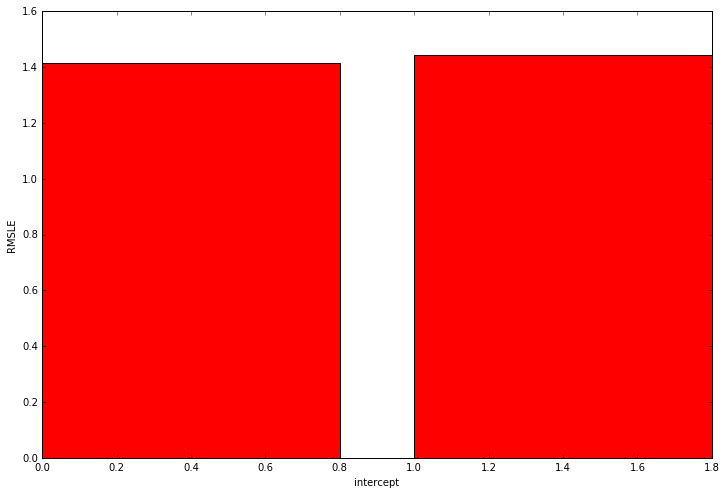

In [62]:
#截距对模型的影响
params=[False, True]
metrics =[evaluate(train, test, 10, 0.1, 1.0,'l2', param) for param in params]
for i in range(len(params)):
    print ('the rmsle:%f when intercept:%f'%(metrics[i],params[i]))

#绘制L2正则化系数与RMSLE的关系图：
plt.bar(params, metrics, color='r')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.xlabel('intercept')
plt.ylabel('RMSLE')
plt.show()



In [63]:
#同理，我们来对决策树来做一个相同的探讨：
def evaluate_dt(train, test, maxDepth, maxBins): 
    model =DecisionTree.trainRegressor(train,{},impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    predictions = model.predict(test.map(lambda point: point.features)) 
    actual = test.map(lambda point: point.label) 
    actual_vs_predictions = actual.zip(predictions) 
    rmsle = np.sqrt(actual_vs_predictions.map(lambda kv: squared_log_error(kv[0],kv[1])).mean())
    return rmsle

树的不同最大深度对性能影响：




我们通常希望用更复杂（更深）的决策树提升模型的性能。而较小的树深度类似正则化形式，如线性模型的L2正则化和L1正则化，存在一个最优的树深度能在测试集上获得最优的性能。


the rmsle:1.005040 when maxDepth :1
the rmsle:0.906772 when maxDepth :2
the rmsle:0.801477 when maxDepth :3
the rmsle:0.724565 when maxDepth :4
the rmsle:0.621689 when maxDepth :5
the rmsle:0.416588 when maxDepth :10
the rmsle:0.438248 when maxDepth :20


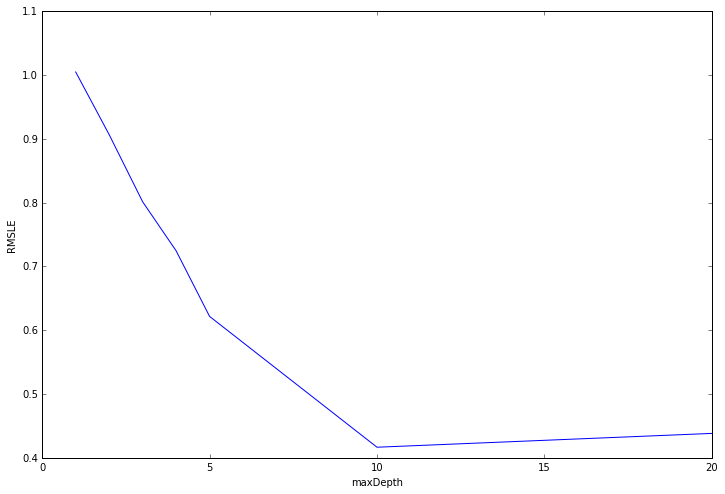

In [64]:
params=[1,2,3,4,5,10,20] 
metrics =[evaluate_dt(train_dt, test_dt, param,32) for param in params]
for i in range(len(params)):    
    print ('the rmsle:%f when maxDepth :%d'%(metrics[i],params[i]))

#绘制树的最大深度与RMSLE的关系图：
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.xlabel('maxDepth')
plt.ylabel('RMSLE')
plt.show()

最大划分数（每个节点分支时最大bin数）对模型的影响

最后，我们来看看划分数对决策树性能的影响。和树的深度一样，更多的划分数会使模型变得更加复杂，并且有助于提升特征维度较大的模型性能。划分数到一定程度之后，对性能的提升帮助不大。实际上， 由于过拟合的原因会导致测试集的性能变差。


the rmsle:1.270302 when maxBins :2
the rmsle:0.786949 when maxBins :4
the rmsle:0.721781 when maxBins :8
the rmsle:0.630364 when maxBins :16
the rmsle:0.621689 when maxBins :32
the rmsle:0.621689 when maxBins :64
the rmsle:0.621689 when maxBins :100


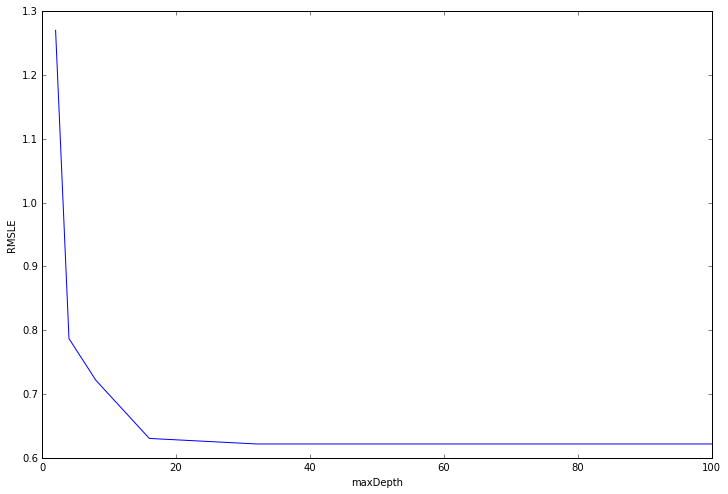

In [65]:
params=[2,4,8,16,32,64,100] 
metrics =[evaluate_dt(train_dt, test_dt,5, param) for param in params]
for i in range(len(params)):    
    print ('the rmsle:%f when maxBins :%d'%(metrics[i],params[i]))

#绘制树的最大划分数与RMSLE的关系图：
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.xlabel('maxDepth')
plt.ylabel('RMSLE')
plt.show()

从上述结果可以看出，最大划分数会影响模型的性能，但是当最大划分数达到30之后，模型性能基本上没有获得提升。最优的最大划分数是在30到35之间。

In [ ]:
#结合以上结果做一个总测试
params_iter = [1, 5, 10, 20, 50, 100]
params_step=[0.01,0.025,0.05,0.1,0.5,1.0] 
params_l2=[0.0,0.01,0.1,1.0,5.0,10.0,20.0]
for iter1 in params_iter:
    for step in params_step:
        for l2 in params_l2:
            metrics =evaluate(train, test, iter1, step, l2,'l2', False)
            print ('the rmsle:%f when iter1 :%d,step :%f,l2 :%f'%(metrics,iter1,step,l2))
            

D:\anaconda1\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :0.000000
the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :0.010000
the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :0.100000
the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :1.000000
the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :5.000000
the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :10.000000
the rmsle:2.913770 when iter1 :1,step :0.010000,l2 :20.000000
the rmsle:2.217222 when iter1 :1,step :0.025000,l2 :0.000000
the rmsle:2.217222 when iter1 :1,step :0.025000,l2 :0.010000
the rmsle:2.217222 when iter1 :1,step :0.025000,l2 :0.100000
the rmsle:2.217222 when iter1 :1,step :0.025000,l2 :1.000000
the rmsle:2.217222 when iter1 :1,step :0.025000,l2 :5.000000
the rmsle:2.217222 when iter1 :1,step :0.025000,l2 :10.000000
